In [8]:
import importlib
import functions
importlib.reload(functions)
functions.set_user('Helen')
data = functions.call_data_clean(p_threshold=1.3)

ATAC = data['ATAC_seq']
ATAC_scores = data['norm_scores']
ATAC_scores_T = ATAC_scores.T
RNA = data['RNA_seq']
RNA_T = data['RNA_seq_T']
Exons = data['exons']


Can one use regression to associate CREs with gene expression?

we will try to answer this question by using linear (lasso) regression to predict gene expression based on accessibility of linked promoter and enhancers (CREs) by linking ATAC peaks to genes via their proximity to the TSS 

here we are plotting an R^2 barplot. Here a high R^2(exlained variance) shows a strong lnk betwenn CREs and gene expression to shows whic CREs play a larger role here. and show us if accessible CREs containe nough information in order to predict gene expression

also we will show a coefficient plot which illustrates whether individual CREs act repressing(negative value) or activating (positive value)

lastly a histogramm showing the distribuiton of r^2 throughout different genes will show how much of the variance of gene expression can be explained for each gene with this approach. 

In [9]:
#lasso regression (r2 barplot, coef plot top gene and r2 distribution histogram)
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns


def get_tss(row):
    # Use the correct column names from Exons
    if row["Strand"] == "+":
        return row["Transcription Start"]
    else:
        return row["Transcription End"]  # or another column if appropriate

Exons["TSS"] = Exons.apply(get_tss, axis=1)

linked_data = []
for _, gene_row in Exons.iterrows():
    gene_name = gene_row["Genname"]
    chrom = gene_row["Chromosom"]
    tss = gene_row["TSS"]

    
    nearby_peaks = ATAC[
        (ATAC["chrom"] == chrom) &
        (np.abs(ATAC["Summit"] - tss) <= 100_000)
    ]

    for _, peak_row in nearby_peaks.iterrows():
        linked_data.append({
            "GeneName": gene_name,
            "PeakID": peak_row.name,
            "DistanceToTSS": np.abs(peak_row["Summit"] - tss)
        })

link_df = pd.DataFrame(linked_data)


In [11]:
#lasso regression definitions
from joblib import Parallel, delayed
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Pre-filter only genes with links
linked_genes = link_df["GeneName"].unique()
genes_to_run = RNA.index.intersection(linked_genes)

# Shared samples between both dataframes
shared_samples = RNA.columns.intersection(ATAC.columns)

# Pretranspose ATAC for faster access later
ATAC_T = ATAC[shared_samples].T
RNA_filtered = RNA.loc[genes_to_run, shared_samples]

# Convert link_df to dictionary {gene: [peak_ids]}
gene_to_peaks = link_df.groupby("GeneName")["PeakID"].apply(list).to_dict()


KeyboardInterrupt: 

In [ ]:
#lasso regression run
def run_lasso_for_gene(gene):
    try:
        peaks = gene_to_peaks.get(gene, [])
        if len(peaks) < 2:
            return None, None

        # Filter ATAC by peaks
        valid_peaks = [p for p in peaks if p in ATAC_T.columns]
        if len(valid_peaks) < 2:
            return None, None

        X = ATAC_T[valid_peaks].fillna(0).values
        y = RNA_filtered.loc[gene].values

        if np.linalg.matrix_rank(X) < 2:
            return None, None

        model = LassoCV(cv=3, n_alphas=20, n_jobs=-1).fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)

        return {
            "Gene": gene,
            "R2": r2,
            "Num_CRs": X.shape[1]
        }, pd.Series(model.coef_, index=valid_peaks)

    except Exception as e:
        print(f"Error with {gene}: {e}")
        return None, None

# Run in parallel with tqdm support
from joblib import parallel_backend

with parallel_backend("loky"):
    parallel_results = list(tqdm(
        Parallel(n_jobs=-1)(delayed(run_lasso_for_gene)(gene) for gene in genes_to_run),
        total=len(genes_to_run),
        desc="Running Lasso"
    ))

# Collect results
results = []
coefs = {}

for res, coef in parallel_results:
    if res is not None:
        results.append(res)
        coefs[res['Gene']] = coef

# To DataFrame
results_df = pd.DataFrame(results).sort_values("R2", ascending=False)


In [ ]:
# lasso rg plot top gene coefficients
top_gene = results_df.iloc[0]["Gene"]
top_coef_series = coefs[top_gene]

plt.figure(figsize=(10, 4))
top_coef_series.plot(kind='bar', color=['red' if v < 0 else 'blue' for v in top_coef_series])
plt.title(f"Lasso Coefficients for Gene {top_gene}")
plt.ylabel("Effect on Expression")
plt.xlabel("CRE (ATAC peak)")
plt.tight_layout()
plt.show()

# Histogram of R² scores
plt.figure(figsize=(8, 4))
sns.histplot(results_df['R2'], bins=10, kde=True)
plt.title("Histogram of Variance Explained (R²) by CREs")
plt.xlabel("R² Score")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()

# bar plot of R² scores (for each gene)
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x="Gene", y="R2", palette="viridis")
plt.title("Variance in Gene Expression Explained by Linked CREs")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


our histogram is conclusive with what is normally expected from real data. A high R^2 value indicates strong CRE regulation. It is shown, that many genes are higly independent from CREs (low R^2 value)e.g houskeeping, stable genes, most with R^2 between 0.2-0.9 are partially regulated by nearby CREs, and lastly there is a long tail until R^2=1 which show that some genes are dominantly regulated by local CREs (lineage specific enhancer control) the top 5 being  qsec1,	Nap1l1,	Cdk4,	Tnfrsf1b and Rgs3

now we will show how much of the variance of gene expression can be explained for each gene with this approach. By showing the distribution of R^2 across genes.

now will will look at how the coefficients differ when this analysis is performed on only abT and gdT cells?
This asks:

How does the importance of each CRE (in predicting gene expression) change when we restrict analysis to only our specific lineage instaead of to using all samples?

Available keys in data: ['ATAC_seq', 'ATAC_seq_T', 'ATAC_seq_scores_no_norm', 'norm_scores', 'RNA_seq', 'RNA_seq_T', 'QC_metrics', 'exons', 'list_ATAC_stem_Tc_Bc', 'list_ATAC_diff_Tc_all', 'list_ATAC_diff_Tc_pre_ab_act', 'list_ATAC_diff_Tc_gd', 'list_ATAC_Tc_ab', 'list_ATAC_Tc_ab_gd', 'list_ATAC_Tc_all', 'test1', 'top2500std', 'ab_tc', 'gd_tc', 'ab_gd_tc']
Type of atac_abgd: <class 'pandas.core.frame.DataFrame'>
Type of atac_abgd.index: <class 'pandas.core.indexes.base.Index'>


c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.435e-05, tolerance: 8.093e-05
  model = cd_fast.enet_coordinate_descent(
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e-03, tolerance: 8.093e-05
  model = cd_fast.enet_coordinate_descent(
c:\Users\helen\OneDrive\Documents\GitHub\abT-gdT-cells-Team3\henv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the nu

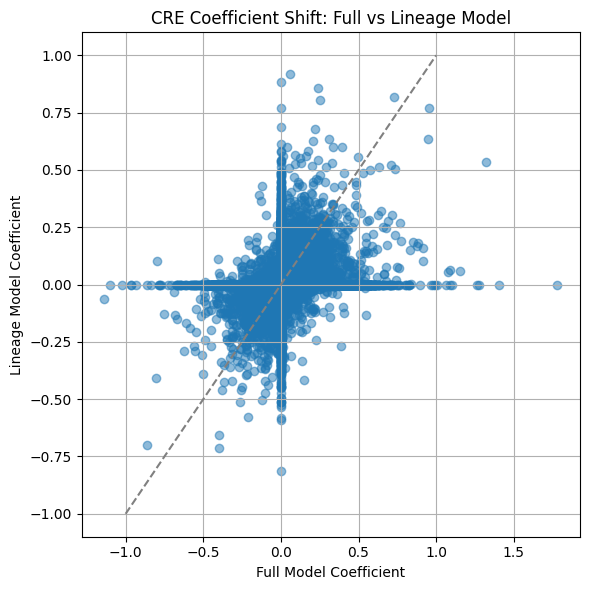

In [ ]:
#coefficient plot for subset ab and gd t cells
import importlib
import functions
importlib.reload(functions)
functions.set_user('Helen')
data = functions.call_data_clean(p_threshold=1.3)


print("Available keys in data:", list(data.keys()))
atac_abgd_cols= data['list_ATAC_Tc_ab_gd']
atac_abgd = data['ATAC_seq'].loc[:, atac_abgd_cols]
ab_gd= data['ab_gd_tc']
rna_abgd = data['RNA_seq'].loc[:, ab_gd]

print("Type of atac_abgd:", type(atac_abgd))
print("Type of atac_abgd.index:", type(atac_abgd.index))

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import numpy as np

abgd_results = []

for gene, group in link_df.groupby("GeneName"):
    if gene not in rna_abgd.index:
        continue
    y = rna_abgd.loc[gene].values

    peak_ids = group["PeakID"].values
    # Only keep peak_ids that are in atac_abgd

    valid_peak_ids = [pid for pid in peak_ids if pid in atac_abgd.index ]
    if len(valid_peak_ids) < 2:
        continue

    x = atac_abgd.loc[valid_peak_ids].T.values  # shape: (samples, peaks)

    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)

    model_lineage = LassoCV(cv=5).fit(x_scaled, y)

    abgd_results.append({
        "GeneName": gene,
        "PeakIDs": valid_peak_ids,
        "LineageCoefs": model_lineage.coef_
    })

full_model_results = []
for gene, coef_series in coefs.items():
    full_model_results.append({
        "GeneName": gene,
        "PeakIDs": list(coef_series.index),
        "FullCoefs": coef_series.values
    })

comparison = []

for lineage in abgd_results:
    gene = lineage["GeneName"]
    peak_ids = lineage["PeakIDs"]

    full = next(
        (f for f in full_model_results if f["GeneName"] == gene and list(f["PeakIDs"]) == list(peak_ids)), 
        None
    )
    
    if full is None:
        continue

    diff = full["FullCoefs"] - lineage["LineageCoefs"]

    for i, peak in enumerate(peak_ids):
        comparison.append({
            "GeneName": gene,
            "PeakID": peak,
            "FullCoef": full["FullCoefs"][i],
            "LineageCoef": lineage["LineageCoefs"][i],
            "Difference": diff[i]
        })
        
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

comp_df = pd.DataFrame(comparison)

plt.figure(figsize=(6, 6))
plt.scatter(comp_df["FullCoef"], comp_df["LineageCoef"], alpha=0.5)
plt.plot([-1, 1], [-1, 1], linestyle="--", color="gray")  # identity line
plt.xlabel("Full Model Coefficient")
plt.ylabel("Lineage Model Coefficient")
plt.title("CRE Coefficient Shift: Full vs Lineage Model")
plt.grid(True)
plt.tight_layout()
plt.show()

#too large to run
# pivot = comp_df.pivot(index="GeneName", columns="PeakID", values="Difference")
#plt.figure(figsize=(12, 6))
#sns.heatmap(pivot.fillna(0), cmap="coolwarm", center=0)
#plt.title("Coefficient Differences (Full - Lineage)")
#plt.xlabel("CRE (Peak)")
#plt.ylabel("Gene")
#plt.tight_layout()
#plt.show()



Interpretation
Points far from diagonal in the scatterplot = CREs whose importance changes between full and lineage models.

Positive differences: CRE is stronger in full model than in lineage (possibly due to other lineages).

Negative differences: CRE is stronger in lineage (lineage-specific regulation).

Heatmap: identifies which CREs are lineage-specific regulators.

now we will analize which CREs are active in ab_tc & gd_tc cell lineages, by ranking different CREs absolute regression coefficients in a CRE-bipartile network graph a CRE importance heatmap and a barplot of top CREs for our specific lineage whereas CREs at the top of the barplot are likely to drive expression of lineage-specific genes. 

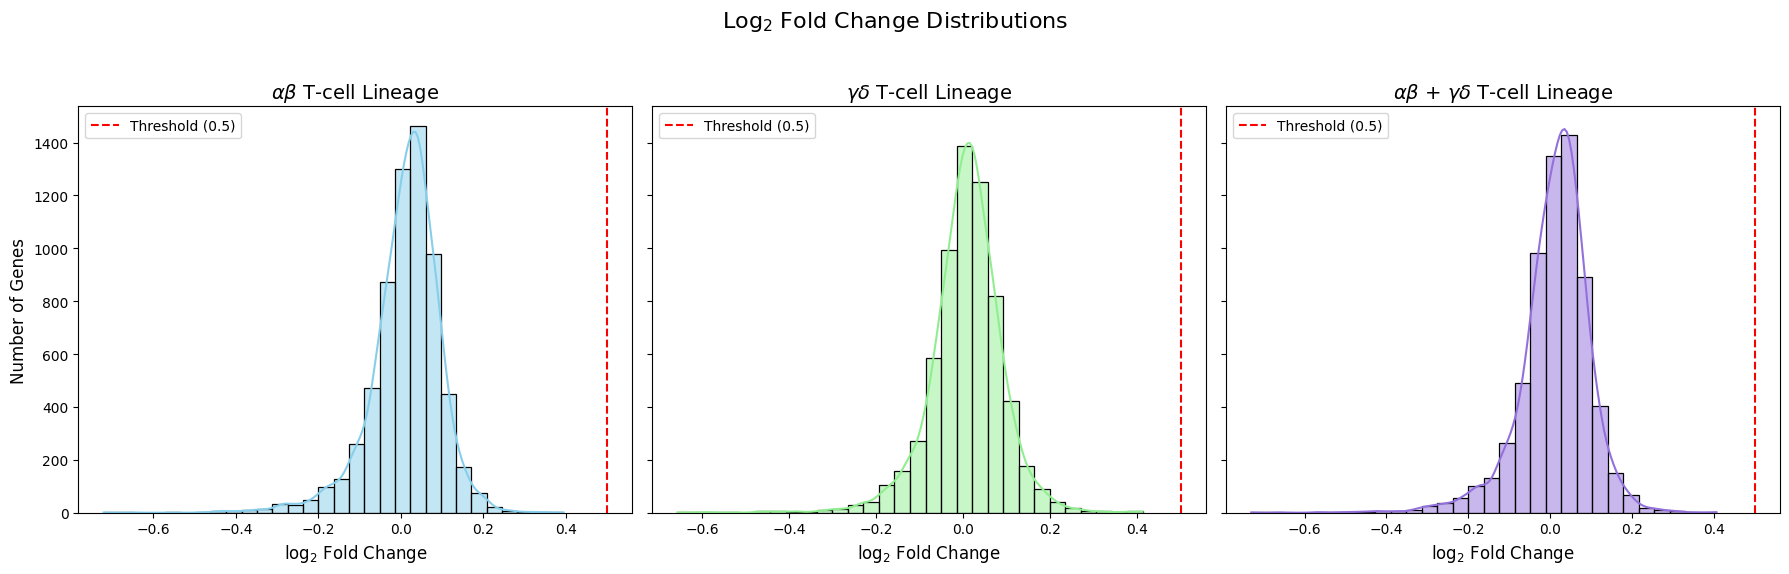

NameError: name 'results_df' is not defined

<Figure size 1200x600 with 0 Axes>

In [12]:
#CRes axtive in our lineage, bipartile plot, heatmap and barplot of top cres

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import importlib
import functions
importlib.reload(functions)
functions.set_user('Helen')
data = functions.call_data_clean(p_threshold=1.3)

logfc2_threshold = 0.5
top_cres_to_plot = 20
epsi = 1e-3

ab_gd= data['ab_gd_tc']
ab= data['ab_tc']
gd= data['gd_tc']
RNA_T = data['RNA_seq_T']

#helper functions

def calculate_log_fold_change(target_cell_types: list, full_rna_data: pd.DataFrame, epsilon: float) -> pd.Series:
    is_target_cell = full_rna_data.index.isin(target_cell_types)
    is_other_cell = ~is_target_cell

    target_samples_expr = full_rna_data[is_target_cell]
    other_samples_expr = full_rna_data[is_other_cell]

    if target_samples_expr.empty or other_samples_expr.empty:
        return pd.Series(dtype=float, index=full_rna_data.columns)

    mean_expr_target = target_samples_expr.mean(axis=0)
    mean_expr_other = other_samples_expr.mean(axis=0)
    
    common_genes = mean_expr_target.index.intersection(mean_expr_other.index)
    mean_expr_target = mean_expr_target[common_genes]
    mean_expr_other = mean_expr_other[common_genes]

    log_fc = np.log2((mean_expr_target + epsilon) / (mean_expr_other + epsilon))
    return log_fc.sort_index()

def calculate_cre_impact(specific_genes: list, coefs_data: dict) -> pd.Series:
    cre_impact = defaultdict(float)
    if not specific_genes:
        return pd.Series(dtype=float)

    for gene in specific_genes:
        if gene in coefs_data:
            coef_entry = coefs_data[gene]
            current_coefs = pd.Series(coef_entry) if isinstance(coef_entry, (pd.Series, dict)) else pd.Series([coef_entry])
            current_coefs_numeric = pd.to_numeric(current_coefs, errors='coerce').dropna()

            if not current_coefs_numeric.empty:
                for cre, val in current_coefs_numeric.items():
                    cre_impact[cre] += np.abs(val)
    
    impact_series = pd.Series(cre_impact)
    return pd.to_numeric(impact_series, errors='coerce').dropna().sort_values(ascending=False)


# big analysis

# Calculate Log2 Fold Changes based on cell types in RNA_T.index
log_fc_abgd = calculate_log_fold_change(ab_gd, RNA_T, epsi)
log_fc_ab = calculate_log_fold_change(ab, RNA_T, epsi)
log_fc_gd = calculate_log_fold_change(gd, RNA_T, epsi)

# Identify specific genes
abgd_specific_genes = log_fc_abgd[log_fc_abgd > logfc2_threshold].index.tolist() if not log_fc_abgd.empty else []
ab_specific_genes = log_fc_ab[log_fc_ab > logfc2_threshold].index.tolist() if not log_fc_ab.empty else []
gd_specific_genes = log_fc_gd[log_fc_gd > logfc2_threshold].index.tolist() if not log_fc_gd.empty else []

#only modeled genes
abgd_genes_modeled = [g for g in abgd_specific_genes if g in coefs]
ab_genes_modeled = [g for g in ab_specific_genes if g in coefs]
gd_genes_modeled = [g for g in gd_specific_genes if g in coefs]

# CRE-Impact Scores
cre_impact_series_abgd = calculate_cre_impact(abgd_genes_modeled, coefs)
cre_impact_series_ab = calculate_cre_impact(ab_genes_modeled, coefs)
cre_impact_series_gd = calculate_cre_impact(gd_genes_modeled, coefs)

# now for the plots

# Log2 Fold Change Distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
plot_configs = [
    (log_fc_ab, r"$\alpha\beta$ T-cell Lineage", 'skyblue'),
    (log_fc_gd, r"$\gamma\delta$ T-cell Lineage", 'lightgreen'),
    (log_fc_abgd, r"$\alpha\beta$ + $\gamma\delta$ T-cell Lineage", 'mediumpurple')
]
for i, (log_fc, title, color) in enumerate(plot_configs):
    ax = axs[i]
    if not log_fc.empty:
        sns.histplot(log_fc, bins=30, kde=True, ax=ax, color=color, edgecolor='black')
        ax.axvline(logfc2_threshold, color='red', linestyle='--', label=f'Threshold ({logfc2_threshold})')
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"log$_2$ Fold Change", fontsize=12)
        if i == 0: ax.set_ylabel("Number of Genes", fontsize=12)
        ax.legend()
    else:
        ax.set_title(title, fontsize=14)
        ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_xlabel(r"log$_2$ Fold Change", fontsize=12)

plt.suptitle("Log$_2$ Fold Change Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# R-squared Scores
plt.figure(figsize=(12, 6))
if not results_df.empty:
    sns.barplot(data=results_df.head(top_cres_to_plot), x="Gene", y="R2", palette="viridis")
    plt.title("Variance Explained by Linked CREs (R² Score)", fontsize=16)
    plt.ylabel("R² Score", fontsize=12)
    plt.xlabel("Gene", fontsize=12)
    plt.xticks(rotation=75, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Top Gene Effect (Lasso Coefficients for a Single Gene)
if results_df is not None and not results_df.empty and results_df.shape[0] > 0 and results_df.iloc[0]["Gene"] in coefs:
    top_gene = results_df.iloc[0]["Gene"]
    top_coef_series = pd.to_numeric(pd.Series(coefs[top_gene]), errors='coerce').dropna()
    if not top_coef_series.empty:
        plt.figure(figsize=(15, 7))
        top_coef_series.plot(kind='bar', color=['red' if v < 0 else 'blue' for v in top_coef_series])
        plt.title(f"Lasso Coefficients for Gene: {top_gene}", fontsize=16)
        plt.ylabel("Effect on Expression", fontsize=12)
        plt.xlabel("CRE", fontsize=12)
        plt.xticks(rotation=75, ha='right', fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

# Histogram of Explained Variance (R²)
plt.figure(figsize=(9, 5))
if not results_df.empty:
    sns.histplot(results_df['R2'], bins=15, kde=True, color='teal', edgecolor='black')
    plt.title("Distribution of Variance Explained (R²)", fontsize=16)
    plt.xlabel("R² Score", fontsize=12)
    plt.ylabel("Number of Genes", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Top CREs Regulating Lineage-Specific Genes
fig, axs = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
cre_plot_configs = [
    (cre_impact_series_ab, r"$\alpha\beta$ T-cell Specific Genes", 'skyblue'),
    (cre_impact_series_gd, r"$\gamma\delta$ T-cell Specific Genes", 'lightgreen'),
    (cre_impact_series_abgd, r"$\alpha\beta$ + $\gamma\delta$ T-cell Specific Genes", 'mediumpurple')
]
for i, (plot_data, title, color) in enumerate(cre_plot_configs):
    ax = axs[i]
    plot_series = plot_data.head(top_cres_to_plot)
    if not plot_series.empty:
        plot_series.plot(kind='bar', color=color, ax=ax, edgecolor='black')
        ax.set_title(f"Top CREs for {title}", fontsize=14)
        ax.set_xlabel("Cis-Regulatory Element", fontsize=12)
        if i == 0: ax.set_ylabel("Cumulative Absolute Coefficient", fontsize=12)
        ax.tick_params(axis='x', rotation=75, ha='right', fontsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
    else:
        ax.set_title(f"Top CREs for {title}", fontsize=14)
        ax.text(0.5, 0.5, "No data", ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_xlabel("Cis-Regulatory Element", fontsize=12)

plt.suptitle("Top Cis-Regulatory Elements (CREs) Regulating Lineage-Specific Genes", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


